# Exploration Détaillée - Fraud Detection IBM

**Objectif** : Analyser les données du challenge, identifier les problèmes (labels, cold-start, données manquantes) et préparer le preprocessing.

**Dataset** :
- `transactions_train.csv` : transactions d'entraînement
- `train_fraud_labels.json` : labels fraude (Yes/No)
- `evaluation_features.csv` : transactions pour évaluation
- `users_data.csv` : profils utilisateurs
- `cards_data.csv` : informations cartes
- `mcc_codes.json` : catégories marchands

## Imports et Configuration

In [29]:
import os
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Config affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Chemins
ROOT = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
DATA_DIR = ROOT / 'data'
OUTPUT_DIR = ROOT / 'output'
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Workspace : {ROOT}")
print(f"Data directory : {DATA_DIR}")

Workspace : /Users/mimomiel/Library/CloudStorage/OneDrive-DeVinci/Travaux A5/BI Pipeline/hackaton_finance_team2
Data directory : /Users/mimomiel/Library/CloudStorage/OneDrive-DeVinci/Travaux A5/BI Pipeline/hackaton_finance_team2/data


## Chargement des Données

### 1. Transactions d'entraînement

In [30]:
# Transactions train
tx_train = pd.read_csv(DATA_DIR / 'transactions_train.csv')
print(f"Transactions train : {tx_train.shape[0]:,} lignes × {tx_train.shape[1]} colonnes")
print(f"\nColonnes : {list(tx_train.columns)}")
tx_train.head()

Transactions train : 210,000 lignes × 12 colonnes

Colonnes : ['transaction_id', 'date', 'client_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors']


,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,19765990,2017-07-07 09:53:00,1581,2519,$12.35,Chip Transaction,20519,Arnold,MO,63010.0,5942,NaN
1,22160255,2018-11-26 17:44:00,1862,4049,$58.29,Chip Transaction,98648,Des Moines,IA,50313.0,5814,NaN
2,17566794,2016-03-26 12:42:00,1967,3367,$11.03,Chip Transaction,46978,Lake Forest,CA,92630.0,5411,NaN
3,17318690,2016-02-01 08:30:00,921,3457,$85.74,Chip Transaction,63701,Rush,NY,14543.0,5411,NaN
4,20994060,2018-03-24 14:42:00,456,2800,$13.43,Chip Transaction,83271,Estero,FL,33928.0,4214,NaN


### 2. Labels Fraude (DIAGNOSTIC)

In [31]:
# Charger labels et diagnostiquer le format
labels_path = DATA_DIR / 'train_fraud_labels.json'
print(f"Fichier : {labels_path}")
print(f"Taille : {labels_path.stat().st_size / 1024 / 1024:.2f} MB\n")

# Lire le JSON
with open(labels_path, 'r') as f:
    labels_data = json.load(f)

# Le JSON a une structure imbriquée avec clé "target"
if isinstance(labels_data, dict) and 'target' in labels_data:
    print("Structure détectée : {'target': {...}}")
    labels_raw = labels_data['target']
else:
    labels_raw = labels_data

print(f"Type chargé : {type(labels_raw)}")
print(f"Nombre de clés : {len(labels_raw):,}")

# Échantillon des 10 premières clés
sample_keys = list(labels_raw.keys())[:10]
print(f"\nÉchantillon (10 premières clés) :")
for k in sample_keys:
    print(f"  {k}: {labels_raw[k]}")

# Distribution des valeurs
values_count = pd.Series(labels_raw.values()).value_counts()
print(f"\nDistribution des valeurs :")
print(values_count)

Fichier : /Users/mimomiel/Library/CloudStorage/OneDrive-DeVinci/Travaux A5/BI Pipeline/hackaton_finance_team2/data/train_fraud_labels.json
Taille : 3.61 MB

Structure détectée : {'target': {...}}
Type chargé : <class 'dict'>
Nombre de clés : 210,000

Échantillon (10 premières clés) :
  19765990: No
  22160255: No
  17566794: No
  17318690: No
  20994060: No
  20501200: No
  18454176: No
  21998064: No
  18977227: No
  17244867: No

Distribution des valeurs :
No     209685
Yes       315
Name: count, dtype: int64


### 3. Normalisation des Labels (Yes/No → 0/1)

In [32]:
def normalize_label(v):
    """Convertir Yes/No en 1/0"""
    if v is None:
        return None
    if isinstance(v, (int, float)):
        return int(v)
    sv = str(v).strip().lower()
    if sv in ('yes', 'y', '1', 'true', 't'):
        return 1
    if sv in ('no', 'n', '0', 'false', 'f'):
        return 0
    return None

# Normaliser
labels_normalized = {str(k): normalize_label(v) for k, v in labels_raw.items()}

# Statistiques
values = list(labels_normalized.values())
n_total = len(values)
n_fraud = sum(1 for v in values if v == 1)
n_normal = sum(1 for v in values if v == 0)
n_unknown = sum(1 for v in values if v is None)

print(f"Labels normalisés :")
print(f"  Total : {n_total:,}")
print(f"  Fraude (1) : {n_fraud:,} ({n_fraud/n_total*100:.2f}%)")
print(f"  Normal (0) : {n_normal:,} ({n_normal/n_total*100:.2f}%)")
print(f"  Inconnu (None) : {n_unknown:,}")

# Créer DataFrame labels
df_labels = pd.DataFrame([
    {'transaction_id': str(k), 'is_fraud': v}
    for k, v in labels_normalized.items()
])

print(f"\nDataFrame labels créé : {df_labels.shape}")
df_labels.head(10)

Labels normalisés :
  Total : 210,000
  Fraude (1) : 315 (0.15%)
  Normal (0) : 209,685 (99.85%)
  Inconnu (None) : 0

DataFrame labels créé : (210000, 2)

DataFrame labels créé : (210000, 2)


,transaction_id,is_fraud
0,19765990,0
1,22160255,0
2,17566794,0
3,17318690,0
4,20994060,0
5,20501200,0
6,18454176,0
7,21998064,0
8,18977227,0
9,17244867,0


### 4. Autres Fichiers

In [33]:
# Evaluation features
tx_eval = pd.read_csv(DATA_DIR / 'evaluation_features.csv')
print(f"Evaluation features : {tx_eval.shape[0]:,} lignes × {tx_eval.shape[1]} colonnes")

# Users
users = pd.read_csv(DATA_DIR / 'users_data.csv')
print(f"Users data : {users.shape[0]:,} lignes × {users.shape[1]} colonnes")

# Cards (si existe)
cards_path = DATA_DIR / 'cards_data.csv'
if cards_path.exists():
    cards = pd.read_csv(cards_path)
    print(f"Cards data : {cards.shape[0]:,} lignes × {cards.shape[1]} colonnes")
else:
    cards = None
    print("Cards data : non trouvé")

# MCC codes
mcc_path = DATA_DIR / 'mcc_codes.json'
if mcc_path.exists():
    with open(mcc_path, 'r') as f:
        mcc_codes = json.load(f)
    print(f"MCC codes : {len(mcc_codes)} catégories")
else:
    mcc_codes = None
    print("MCC codes : non trouvé")

Evaluation features : 90,000 lignes × 12 colonnes
Users data : 2,000 lignes × 14 colonnes
Cards data : 6,146 lignes × 13 colonnes
MCC codes : 109 catégories


## Jointure Transactions + Labels

In [34]:
# Convertir transaction_id en string pour la jointure
tx_train['transaction_id'] = tx_train['transaction_id'].astype(str)

# Jointure
tx_labeled = tx_train.merge(df_labels, on='transaction_id', how='left')

print(f"Transactions avec labels : {tx_labeled.shape}")
print(f"\nStatistiques labels après jointure :")
print(f"  Transactions étiquetées : {tx_labeled['is_fraud'].notnull().sum():,}")
print(f"  Transactions sans label : {tx_labeled['is_fraud'].isnull().sum():,}")
print(f"\n  Distribution fraude :")
print(tx_labeled['is_fraud'].value_counts(dropna=False))

tx_labeled.head(10)

Transactions avec labels : (210000, 13)

Statistiques labels après jointure :
  Transactions étiquetées : 210,000
  Transactions sans label : 0

  Distribution fraude :
is_fraud
0    209685
1       315
Name: count, dtype: int64


,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud
0,19765990,2017-07-07 09:53:00,1581,2519,$12.35,Chip Transaction,20519,Arnold,MO,63010.0,5942,NaN,0
1,22160255,2018-11-26 17:44:00,1862,4049,$58.29,Chip Transaction,98648,Des Moines,IA,50313.0,5814,NaN,0
2,17566794,2016-03-26 12:42:00,1967,3367,$11.03,Chip Transaction,46978,Lake Forest,CA,92630.0,5411,NaN,0
3,17318690,2016-02-01 08:30:00,921,3457,$85.74,Chip Transaction,63701,Rush,NY,14543.0,5411,NaN,0
4,20994060,2018-03-24 14:42:00,456,2800,$13.43,Chip Transaction,83271,Estero,FL,33928.0,4214,NaN,0
5,20501200,2017-12-09 22:26:00,0,4639,$53.12,Chip Transaction,14040,Morgan,VT,5853.0,5813,NaN,0
6,18454176,2016-10-01 21:40:00,408,4960,$52.86,Chip Transaction,75781,Cable,WI,54821.0,5411,NaN,0
7,21998064,2018-10-23 12:50:00,1432,4929,$35.33,Swipe Transaction,59292,Lake Hopatcong,NJ,7849.0,5813,NaN,0
8,18977227,2017-01-21 09:30:00,177,2681,$188.77,Chip Transaction,86616,Memphis,TN,38104.0,4814,NaN,0
9,17244867,2016-01-16 13:40:00,1895,1090,$27.40,Chip Transaction,68436,Barnegat,NJ,8005.0,4121,NaN,0


## Nettoyage et Parsing

### Colonne `amount`

Parsing des montants :
  Valeurs nulles : 0
  Valeurs négatives : 10,128
  Min : $-500.00
  Max : $2775.67
  Moyenne : $42.55
  Médiane : $28.17


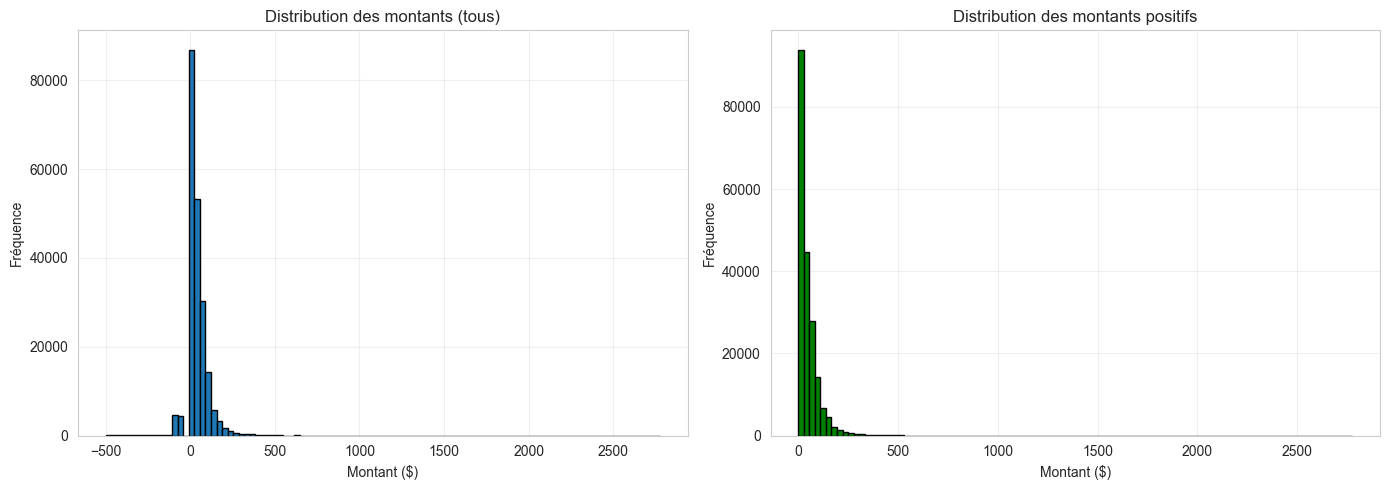

In [35]:
def parse_amount(x):
    """Parser montant : remove $, commas, handle parentheses (negative)"""
    if pd.isna(x):
        return None
    s = str(x).strip()
    neg = False
    if s.startswith('(') and s.endswith(')'):
        neg = True
        s = s[1:-1]
    s = re.sub(r'[^0-9.\-]', '', s)
    if s == '':
        return None
    try:
        val = float(s)
        if neg:
            val = -abs(val)
        return val
    except:
        return None

# Appliquer
tx_labeled['amount_parsed'] = tx_labeled['amount'].apply(parse_amount)

# Stats
print(f"Parsing des montants :")
print(f"  Valeurs nulles : {tx_labeled['amount_parsed'].isnull().sum():,}")
print(f"  Valeurs négatives : {(tx_labeled['amount_parsed'] < 0).sum():,}")
print(f"  Min : ${tx_labeled['amount_parsed'].min():.2f}")
print(f"  Max : ${tx_labeled['amount_parsed'].max():.2f}")
print(f"  Moyenne : ${tx_labeled['amount_parsed'].mean():.2f}")
print(f"  Médiane : ${tx_labeled['amount_parsed'].median():.2f}")

# Distribution
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
tx_labeled['amount_parsed'].hist(bins=100, edgecolor='black')
plt.xlabel('Montant ($)')
plt.ylabel('Fréquence')
plt.title('Distribution des montants (tous)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
tx_labeled[tx_labeled['amount_parsed'] > 0]['amount_parsed'].hist(bins=100, edgecolor='black', color='green')
plt.xlabel('Montant ($)')
plt.ylabel('Fréquence')
plt.title('Distribution des montants positifs')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Analyse Cold-Start

Comparer clients train vs eval

Analyse Cold-Start :
  Clients train : 852
  Clients eval : 362
  Overlap (connus) : 0
  Cold-start (nouveaux) : 362

  Taux de cold-start : 100.0%


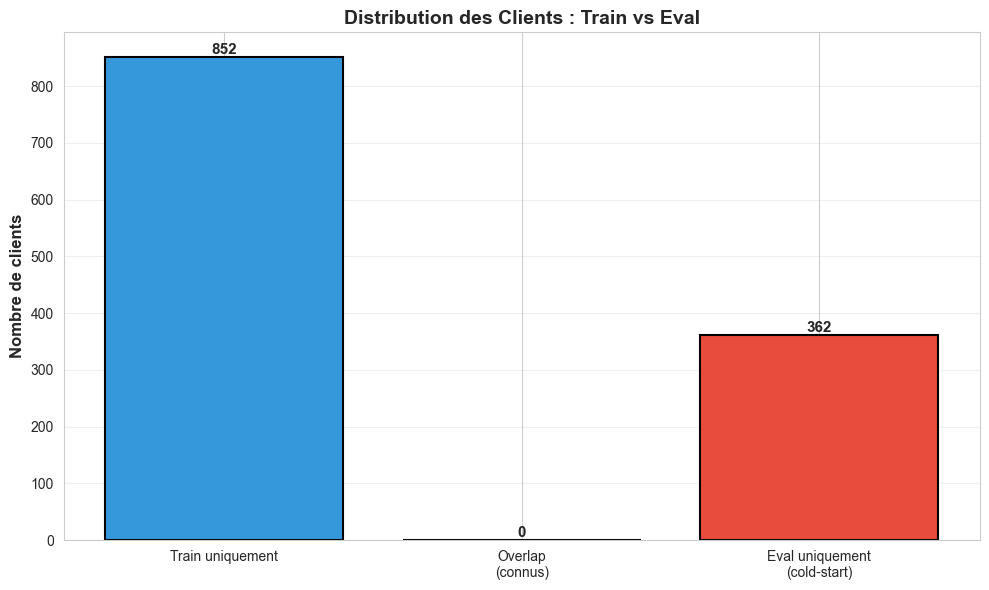

In [36]:
# Clients uniques
train_clients = set(tx_labeled['client_id'].dropna().unique())
eval_clients = set(tx_eval['client_id'].dropna().unique())

overlap = train_clients & eval_clients
cold_start_clients = eval_clients - train_clients

print(f"Analyse Cold-Start :")
print(f"  Clients train : {len(train_clients):,}")
print(f"  Clients eval : {len(eval_clients):,}")
print(f"  Overlap (connus) : {len(overlap):,}")
print(f"  Cold-start (nouveaux) : {len(cold_start_clients):,}")
print(f"\n  Taux de cold-start : {len(cold_start_clients)/len(eval_clients)*100:.1f}%")

# Visu
fig, ax = plt.subplots(figsize=(10, 6))
categories = ['Train uniquement', 'Overlap\n(connus)', 'Eval uniquement\n(cold-start)']
values = [
    len(train_clients - eval_clients),
    len(overlap),
    len(cold_start_clients)
]
colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Nombre de clients', fontsize=12, fontweight='bold')
ax.set_title('Distribution des Clients : Train vs Eval', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

## Analyse des Valeurs Manquantes

Valeurs manquantes (top 10) :
                Missing  Percentage
errors           206727       98.44
zip               26797       12.76
merchant_state    25431       12.11
transaction_id        0        0.00
date                  0        0.00
client_id             0        0.00
card_id               0        0.00
amount                0        0.00
use_chip              0        0.00
merchant_id           0        0.00


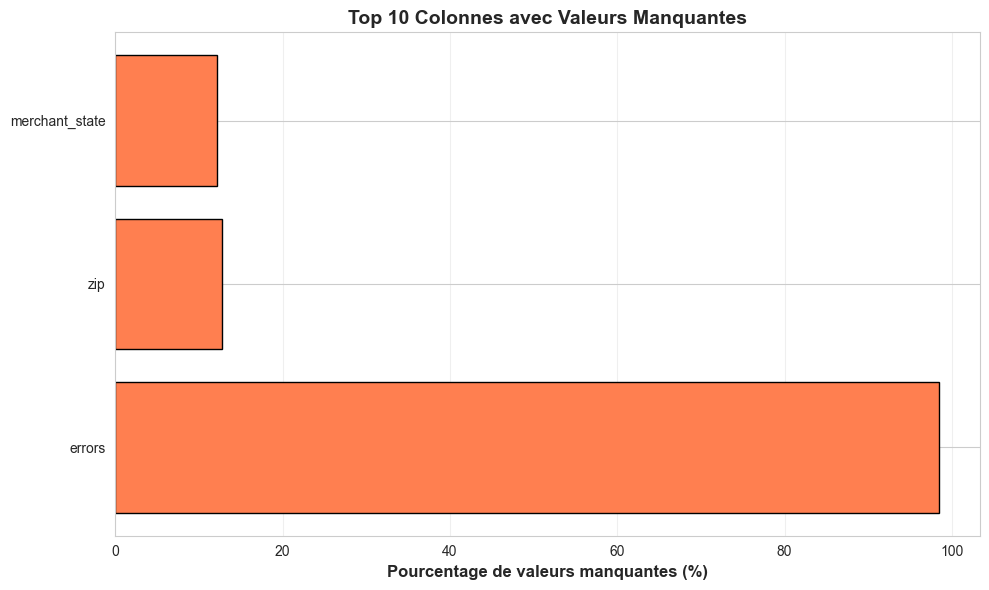

In [37]:
# Valeurs manquantes par colonne
missing = tx_labeled.isnull().sum()
missing_pct = (missing / len(tx_labeled) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing': missing,
    'Percentage': missing_pct
}).sort_values('Missing', ascending=False)

print("Valeurs manquantes (top 10) :")
print(missing_df.head(10))

# Visualisation
top_missing = missing_df[missing_df['Missing'] > 0].head(10)
if not top_missing.empty:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(top_missing.index, top_missing['Percentage'], color='coral', edgecolor='black')
    ax.set_xlabel('Pourcentage de valeurs manquantes (%)', fontsize=12, fontweight='bold')
    ax.set_title('Top 10 Colonnes avec Valeurs Manquantes', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## Top Merchants et MCC

Top 10 Merchants (par volume de transactions) :
merchant_id
59935    9764
61195    9020
27092    8628
39021    6676
43293    5404
14528    5291
22204    5214
50783    4721
60569    4648
75781    4620
Name: count, dtype: int64

Top 10 MCC (par volume de transactions) :
mcc
5411    25633
5499    22912
5541    22098
5812    16080
5912    11981
4784    10911
5300     9336
4829     8628
4121     8165
5814     7845
Name: count, dtype: int64


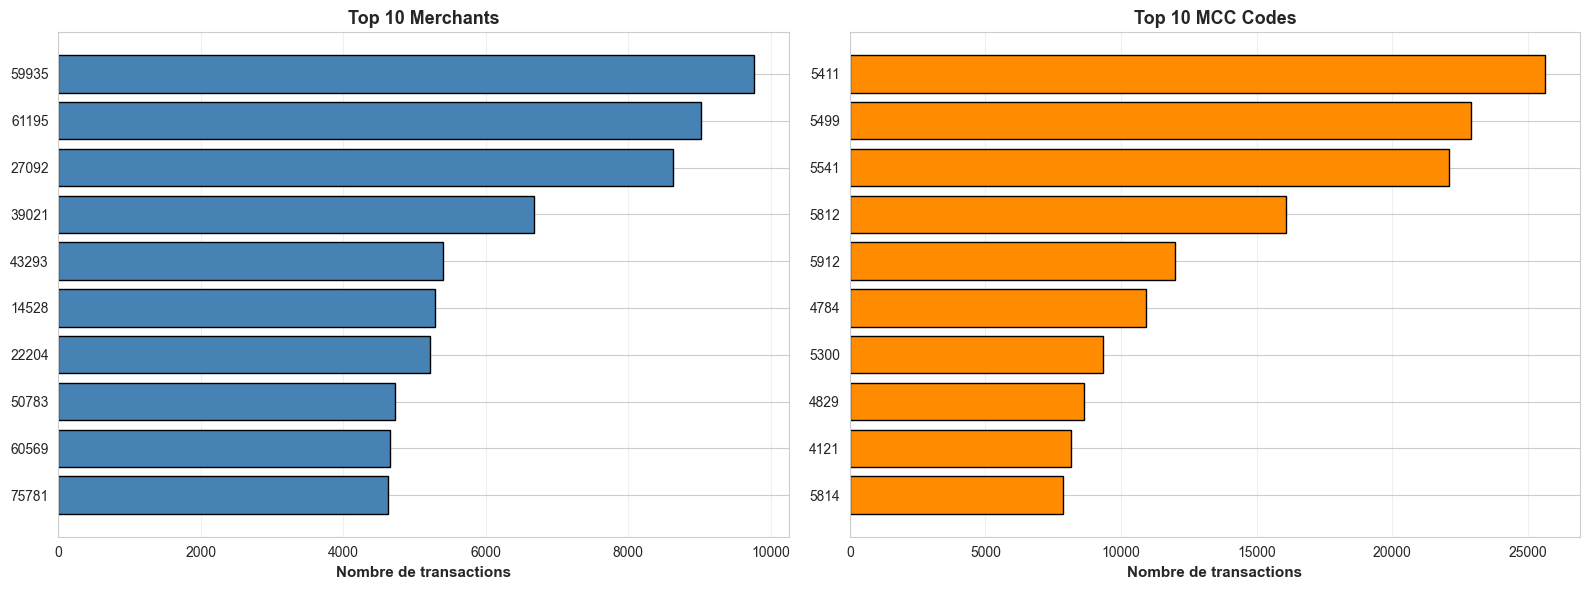

In [38]:
# Top 10 merchants
print("Top 10 Merchants (par volume de transactions) :")
top_merchants = tx_labeled['merchant_id'].value_counts().head(10)
print(top_merchants)

# Top 10 MCC
print("\nTop 10 MCC (par volume de transactions) :")
top_mcc = tx_labeled['mcc'].value_counts().head(10)
print(top_mcc)

# Visu
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Merchants
axes[0].barh(range(len(top_merchants)), top_merchants.values, color='steelblue', edgecolor='black')
axes[0].set_yticks(range(len(top_merchants)))
axes[0].set_yticklabels(top_merchants.index)
axes[0].set_xlabel('Nombre de transactions', fontsize=11, fontweight='bold')
axes[0].set_title('Top 10 Merchants', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# MCC
axes[1].barh(range(len(top_mcc)), top_mcc.values, color='darkorange', edgecolor='black')
axes[1].set_yticks(range(len(top_mcc)))
axes[1].set_yticklabels(top_mcc.index)
axes[1].set_xlabel('Nombre de transactions', fontsize=11, fontweight='bold')
axes[1].set_title('Top 10 MCC Codes', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Analyse de la Fraude

Analyse Fraude :
  Transactions normales : 209,685 (99.85%)
  Transactions frauduleuses : 315 (0.15%)
  Ratio déséquilibre : 1:665.7


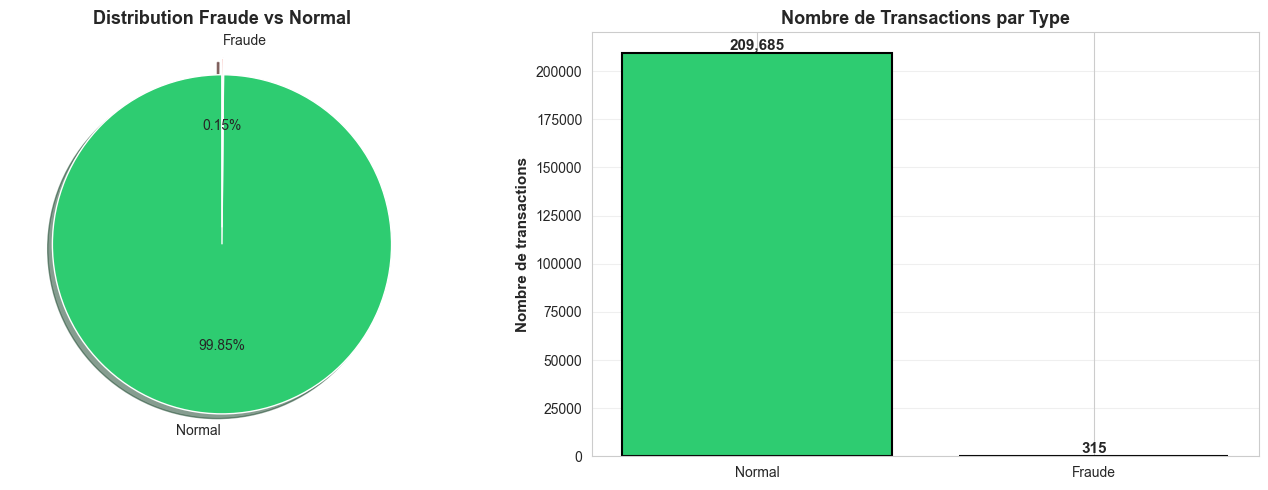

In [39]:
# Statistiques fraude
fraud_stats = tx_labeled[tx_labeled['is_fraud'].notnull()]
n_fraud = (fraud_stats['is_fraud'] == 1).sum()
n_normal = (fraud_stats['is_fraud'] == 0).sum()
fraud_rate = n_fraud / len(fraud_stats) * 100

print(f"Analyse Fraude :")
print(f"  Transactions normales : {n_normal:,} ({100-fraud_rate:.2f}%)")
print(f"  Transactions frauduleuses : {n_fraud:,} ({fraud_rate:.2f}%)")
print(f"  Ratio déséquilibre : 1:{n_normal/n_fraud:.1f}")

# Visu
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
axes[0].pie([n_normal, n_fraud], 
            labels=['Normal', 'Fraude'],
            autopct='%1.2f%%',
            colors=['#2ecc71', '#e74c3c'],
            explode=(0, 0.1),
            shadow=True,
            startangle=90)
axes[0].set_title('Distribution Fraude vs Normal', fontsize=13, fontweight='bold')

# Bar chart
axes[1].bar(['Normal', 'Fraude'], [n_normal, n_fraud], 
           color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Nombre de transactions', fontsize=11, fontweight='bold')
axes[1].set_title('Nombre de Transactions par Type', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, (label, val) in enumerate(zip(['Normal', 'Fraude'], [n_normal, n_fraud])):
    axes[1].text(i, val, f'{val:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Montants : Fraude vs Normal

Montants moyens :
  Normal : $42.45 (médiane: $28.14)
  Fraude : $111.91 (médiane: $73.32)


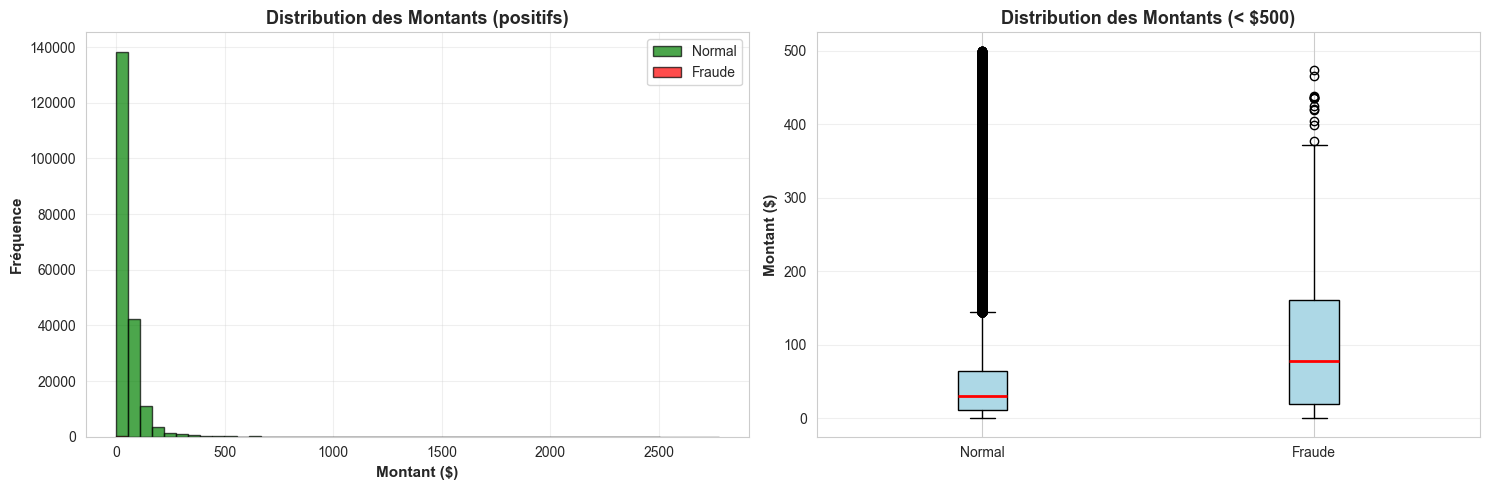

In [40]:
# Comparaison montants
fraud_amounts = fraud_stats[fraud_stats['is_fraud'] == 1]['amount_parsed'].dropna()
normal_amounts = fraud_stats[fraud_stats['is_fraud'] == 0]['amount_parsed'].dropna()

print(f"Montants moyens :")
print(f"  Normal : ${normal_amounts.mean():.2f} (médiane: ${normal_amounts.median():.2f})")
print(f"  Fraude : ${fraud_amounts.mean():.2f} (médiane: ${fraud_amounts.median():.2f})")

# Visu
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogrammes
axes[0].hist(normal_amounts[normal_amounts > 0], bins=50, alpha=0.7, label='Normal', color='green', edgecolor='black')
axes[0].hist(fraud_amounts[fraud_amounts > 0], bins=50, alpha=0.7, label='Fraude', color='red', edgecolor='black')
axes[0].set_xlabel('Montant ($)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Fréquence', fontsize=11, fontweight='bold')
axes[0].set_title('Distribution des Montants (positifs)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
data_box = [
    normal_amounts[(normal_amounts > 0) & (normal_amounts < 500)],
    fraud_amounts[(fraud_amounts > 0) & (fraud_amounts < 500)]
]
axes[1].boxplot(data_box, tick_labels=['Normal', 'Fraude'], patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='black'),
               medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Montant ($)', fontsize=11, fontweight='bold')
axes[1].set_title('Distribution des Montants (< $500)', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Analyse Temporelle (Date)

Plage temporelle :
  Train : 2016-01-01 00:29:00 → 2018-12-31 23:31:00
  Eval  : 2019-01-01 00:05:00 → 2019-10-31 23:52:00


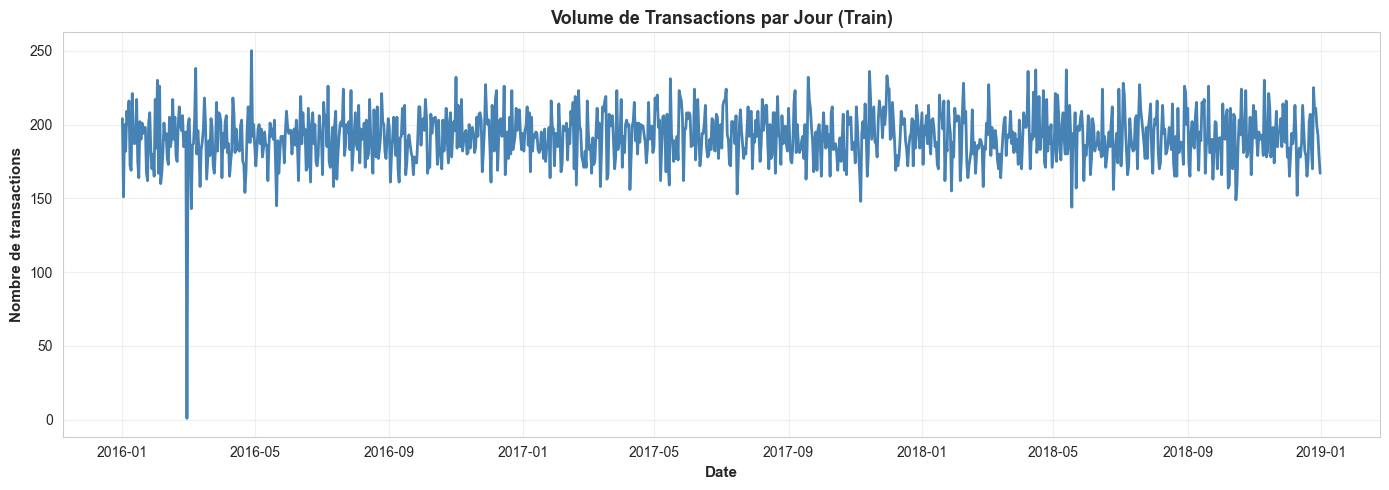

In [41]:
# Parser dates
tx_labeled['date_parsed'] = pd.to_datetime(tx_labeled['date'], errors='coerce')
tx_eval['date_parsed'] = pd.to_datetime(tx_eval['date'], errors='coerce')

print(f"Plage temporelle :")
print(f"  Train : {tx_labeled['date_parsed'].min()} → {tx_labeled['date_parsed'].max()}")
print(f"  Eval  : {tx_eval['date_parsed'].min()} → {tx_eval['date_parsed'].max()}")

# Visu
fig, ax = plt.subplots(figsize=(14, 5))
tx_labeled['date_parsed'].dt.date.value_counts().sort_index().plot(ax=ax, color='steelblue', linewidth=2)
ax.set_xlabel('Date', fontsize=11, fontweight='bold')
ax.set_ylabel('Nombre de transactions', fontsize=11, fontweight='bold')
ax.set_title('Volume de Transactions par Jour (Train)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Résumé Final

# Construire le résumé et l'export
summary = f"""
RÉSUMÉ DE L'EXPLORATION

DONNÉES CHARGÉES
  • Transactions train : {len(tx_labeled):,} lignes
  • Labels fraude      : {len(df_labels):,} transactions
  • Transactions eval  : {len(tx_eval):,} lignes
  • Users data         : {len(users):,} utilisateurs

JOINTURE LABELS
  • Transactions étiquetées : {tx_labeled['is_fraud'].notnull().sum():,}
  • Taux de fraude          : {fraud_rate:.2f}%
  • Ratio déséquilibre      : 1:{n_normal/n_fraud:.1f}

COLD-START
  • Clients train           : {len(train_clients):,}
  • Clients eval            : {len(eval_clients):,}
  • Overlap (connus)        : {len(overlap):,}
  • Cold-start (nouveaux)   : {len(cold_start_clients):,} ({len(cold_start_clients)/len(eval_clients)*100:.1f}%)

MONTANTS
  • Valeurs négatives       : {(tx_labeled['amount_parsed'] < 0).sum():,}
  • Montant moyen (normal)  : ${normal_amounts.mean():.2f}
  • Montant moyen (fraude)  : ${fraud_amounts.mean():.2f}

DONNÉES MANQUANTES (Top 3)
"""

for col, pct in missing_df.head(3).iterrows():
    summary += f"  • {col:20s} : {pct['Percentage']:6.2f}%\n"

summary += "\nPROCHAINES ÉTAPES\n  1. Preprocessing : features temporelles, encoding, agrégations\n  2. Stratégie cold-start : features transactionnelles\n  3. Baseline LightGBM avec validation temporelle\n  4. Intégration IBM watsonX\n"

print(summary)

# Sauvegarder
with open(OUTPUT_DIR / 'exploration_summary.txt', 'w') as f:
    f.write(summary)
print(f"Résumé sauvegardé : {OUTPUT_DIR / 'exploration_summary.txt'}")

In [45]:
summary = f"""
╔════════════════════════════════════════════════════════════════╗
║           RÉSUMÉ DE L'EXPLORATION                           ║
╚════════════════════════════════════════════════════════════════╝

DONNÉES CHARGÉES
  • Transactions train : {len(tx_labeled):,} lignes
  • Labels fraude      : {len(df_labels):,} transactions
  • Transactions eval  : {len(tx_eval):,} lignes
  • Users data         : {len(users):,} utilisateurs

JOINTURE LABELS
  • Transactions étiquetées : {tx_labeled['is_fraud'].notnull().sum():,}
  • Taux de fraude          : {fraud_rate:.2f}%
  • Ratio déséquilibre      : 1:{n_normal/n_fraud:.1f}

OLD-START
  • Clients train           : {len(train_clients):,}
  • Clients eval            : {len(eval_clients):,}
  • Overlap (connus)        : {len(overlap):,}
  • Cold-start (nouveaux)   : {len(cold_start_clients):,} ({len(cold_start_clients)/len(eval_clients)*100:.1f}%)

MONTANTS
  • Valeurs négatives       : {(tx_labeled['amount_parsed'] < 0).sum():,}
  • Montant moyen (normal)  : ${normal_amounts.mean():.2f}
  • Montant moyen (fraude)  : ${fraud_amounts.mean():.2f}

🕳️  DONNÉES MANQUANTES (Top 3)
"""

for col, pct in missing_df.head(3).iterrows():
    summary += f"  • {col:20s} : {pct['Percentage']:6.2f}%\n"

summary += """
╔════════════════════════════════════════════════════════════════╗
║  PROCHAINES ÉTAPES                                          ║
║  1. Preprocessing : features temporelles, encoding, agrégations║
║  2. Stratégie cold-start : features transactionnelles          ║
║  3. Baseline LightGBM avec validation temporelle              ║
║  4. Intégration IBM watsonX                                    ║
╚════════════════════════════════════════════════════════════════╝
"""

print(summary)

# Sauvegarder
with open(OUTPUT_DIR / 'exploration_summary.txt', 'w') as f:
    f.write(summary)
print(f"\nRésumé sauvegardé : {OUTPUT_DIR / 'exploration_summary.txt'}")


╔════════════════════════════════════════════════════════════════╗
║           RÉSUMÉ DE L'EXPLORATION                           ║
╚════════════════════════════════════════════════════════════════╝

DONNÉES CHARGÉES
  • Transactions train : 210,000 lignes
  • Labels fraude      : 210,000 transactions
  • Transactions eval  : 90,000 lignes
  • Users data         : 2,000 utilisateurs

JOINTURE LABELS
  • Transactions étiquetées : 210,000
  • Taux de fraude          : 0.15%
  • Ratio déséquilibre      : 1:665.7

OLD-START
  • Clients train           : 852
  • Clients eval            : 362
  • Overlap (connus)        : 0
  • Cold-start (nouveaux)   : 362 (100.0%)

MONTANTS
  • Valeurs négatives       : 10,128
  • Montant moyen (normal)  : $42.45
  • Montant moyen (fraude)  : $111.91

🕳️  DONNÉES MANQUANTES (Top 3)
  • errors               :  98.44%
  • zip                  :  12.76%
  • merchant_state       :  12.11%

╔════════════════════════════════════════════════════════════════╗
║  P

## Export des Données Nettoyées

# Sauvegarder transactions avec labels et montants parsés
output_path = OUTPUT_DIR / 'transactions_labeled_cleaned.csv'
tx_labeled.to_csv(output_path, index=False)
print(f"Données nettoyées exportées : {output_path}")
print(f"Shape: {tx_labeled.shape}")

In [46]:
# Sauvegarder transactions avec labels et montants parsés
output_path = OUTPUT_DIR / 'transactions_labeled_cleaned.csv'
tx_labeled.to_csv(output_path, index=False)
print(f"Données nettoyées exportées : {output_path}")
print(f"   Shape: {tx_labeled.shape}")

Données nettoyées exportées : /Users/mimomiel/Library/CloudStorage/OneDrive-DeVinci/Travaux A5/BI Pipeline/hackaton_finance_team2/output/transactions_labeled_cleaned.csv
   Shape: (210000, 15)
